In [83]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from pathlib import Path
sns.set_theme(style="darkgrid", palette="tab20")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [84]:
feature_path =  Path(r'X:\20211020_G3BP1\replicate_2\features')
feature_files = feature_path.glob('*cells_feature_values.csv')
feature_files = [str(fyle) for fyle in feature_files]
fv = []

for site, fyle in enumerate(sorted(feature_files)):
    site_fv = pd.read_csv(fyle)
    site_fv['site'] = site
    site_fv['unique_track_id'] = site_fv['track_id'] + site * 1000
    fv.append(site_fv)
    
    
fv = pd.concat(fv)

In [85]:
fv.shape

(14786, 245)

In [86]:
fv.head()

,unique_object_id,timepoint,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,...,orientation_cells_eroded_2,perimeter_cells_eroded_2,solidity_cells_eroded_2,max_intensity_sdcGFP_cells_eroded_2,mean_intensity_sdcGFP_cells_eroded_2,min_intensity_sdcGFP_cells_eroded_2,is_border_cells_eroded_2,count_cells_eroded_2,site,unique_track_id
0,0,0,1,3877,6,6,64,86,4640,31.659015,...,-1.296240,232.183766,0.955433,28.0,9.875399,0.0,0.0,1.0,0,69
1,1,0,2,73392,6,1579,342,1840,87696,177.211249,...,-0.045868,5085.403605,0.221703,1500.0,541.039369,86.0,0.0,1.0,0,9
2,2,0,3,63389,6,1824,336,2043,72270,166.887504,...,-0.102470,2964.152596,0.146468,1262.0,358.699435,23.0,0.0,1.0,0,10
3,3,0,4,185624,144,91,635,587,243536,393.315132,...,0.597653,1846.033621,0.965287,113.0,8.787216,0.0,0.0,1.0,0,11
4,4,0,5,89369,251,1184,576,1638,147550,406.969632,...,-1.038346,1442.678282,0.879976,303.0,12.384824,0.0,0.0,1.0,0,12


# Data clean-up

In [87]:
# remove tracks that contain cells touching the border
fv = fv.groupby('unique_track_id').filter(lambda x: x['is_border'].sum() == 0)
len(fv)

11599

In [88]:
# remove tracks that do not span the whole movie
fv = fv.groupby('unique_track_id').filter(lambda x: len(x) >= 20)
len(fv)

10278

In [89]:
# filter the cells that have been transfected in the first timepoint
positive_tracks = fv['unique_track_id'].loc[(fv['timepoint'] == 0) & (fv['max_intensity_sdcGFP'] > 25)]
fv = fv.loc[fv['unique_track_id'].isin(positive_tracks)]

In [90]:
# remove tracks that have high initial GFP intensity
positive_tracks = fv['unique_track_id'].loc[(fv['timepoint'] == 0) & (fv['max_intensity_sdcGFP'] < 2000)]
fv = fv.loc[fv['unique_track_id'].isin(positive_tracks)]

In [91]:
# remove tracks that have high initial blob count
positive_tracks = fv['unique_track_id'].loc[(fv['timepoint'] == 0) & (fv['blob_count_sdcGFP'] < 50)]
fv = fv.loc[fv['unique_track_id'].isin(positive_tracks)]

In [92]:
# remove tracks that have low overall blob count
fv = fv.groupby('unique_track_id').filter(lambda x: x['blob_count_sdcGFP'].sum() >= 400)

In [93]:
# how many tracks are left?
len(np.unique(fv['unique_track_id']))

58

In [94]:
# add time column
time_resolution_min = 0.5
fv['time'] = fv['timepoint'] * time_resolution_min

# Example plots

[Text(0.5, 0, 'cell area'), Text(0, 0.5, 'mean_intensity_sdcGFP')]

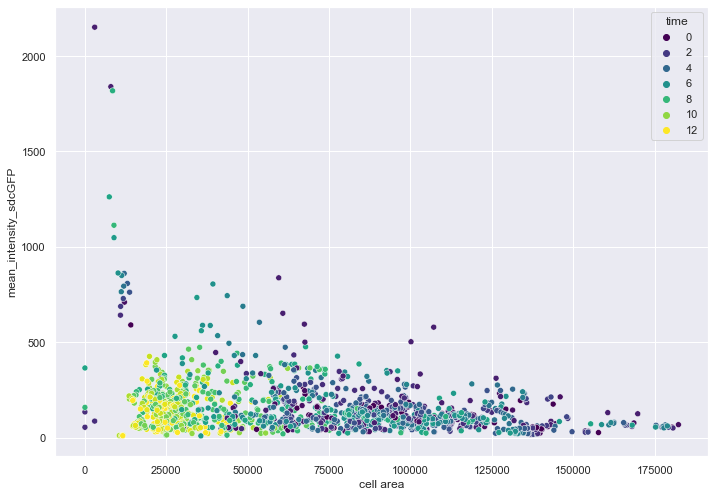

In [95]:
ax = sns.scatterplot(data=fv, x='area', y='mean_intensity_sdcGFP', hue='time', palette='viridis')
ax.set(xlabel='cell area', ylabel='mean_intensity_sdcGFP')

[Text(0.5, 0, 'time (min)'), Text(0, 0.5, 'area nuclei')]

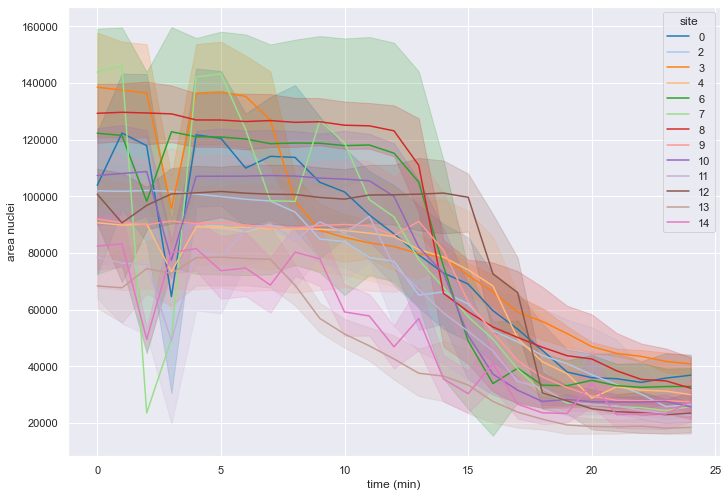

In [96]:
ax = sns.lineplot(data=fv.set_index('unique_object_id'), x='timepoint', y='area', hue='site', palette='tab20')
ax.set(xlabel='time (min)', ylabel='area nuclei')

# Volume and density estimation

In [97]:
# volume = area_pixel * pixel_size_um * imaging_depth_um 
physical_pixel_size_um = 6.5
z_depth_um = 5
magnification = 60

fv['area_cytoplasm_um'] = fv['area'] * (physical_pixel_size_um/magnification)**2
fv['volume_cytoplasm'] = fv['area_cytoplasm_um'] * z_depth_um
fv['blob_sdcGFP_cytoplasm_density'] = fv['blob_count_sdcGFP']/fv['volume_cytoplasm']

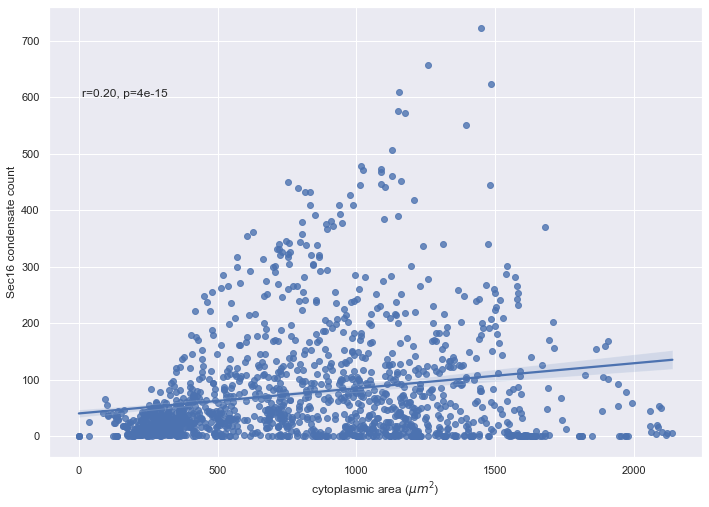

In [98]:
def annotate(ax, data, x, y):
    r, p = sp.stats.pearsonr(data[x], data[y])
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)


ax = sns.regplot(data=fv, x='area_cytoplasm_um', y='blob_count_sdcGFP')
ax.set(xlabel='cytoplasmic area ($\mu m^2$)', ylabel='Sec16 condensate count')

annotate(ax=ax, data=fv, x='area_cytoplasm_um', y='blob_count_sdcGFP')
plt.show()

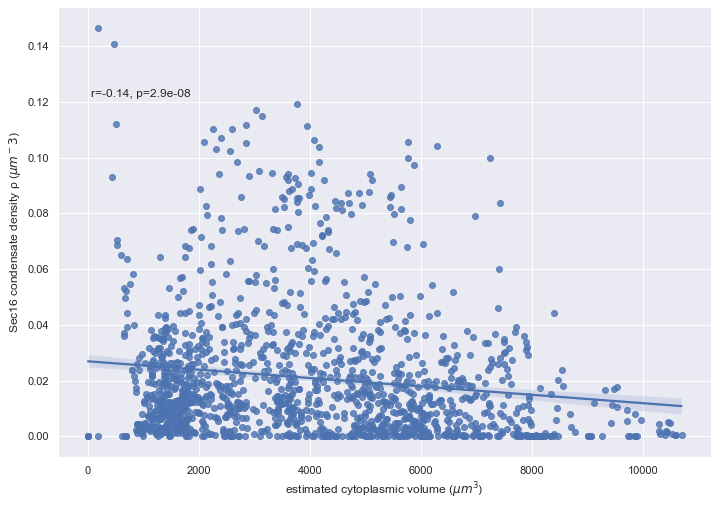

In [99]:
ax = sns.regplot(data=fv, x='volume_cytoplasm', y='blob_sdcGFP_cytoplasm_density')
ax.set(xlabel='estimated cytoplasmic volume ($\mu m^3$)', ylabel='Sec16 condensate density ρ ($\mu m^-3$)')
annotate(ax=ax, data=fv, x='volume_cytoplasm', y='blob_sdcGFP_cytoplasm_density')
plt.show()

# Estimation of nucleation rate

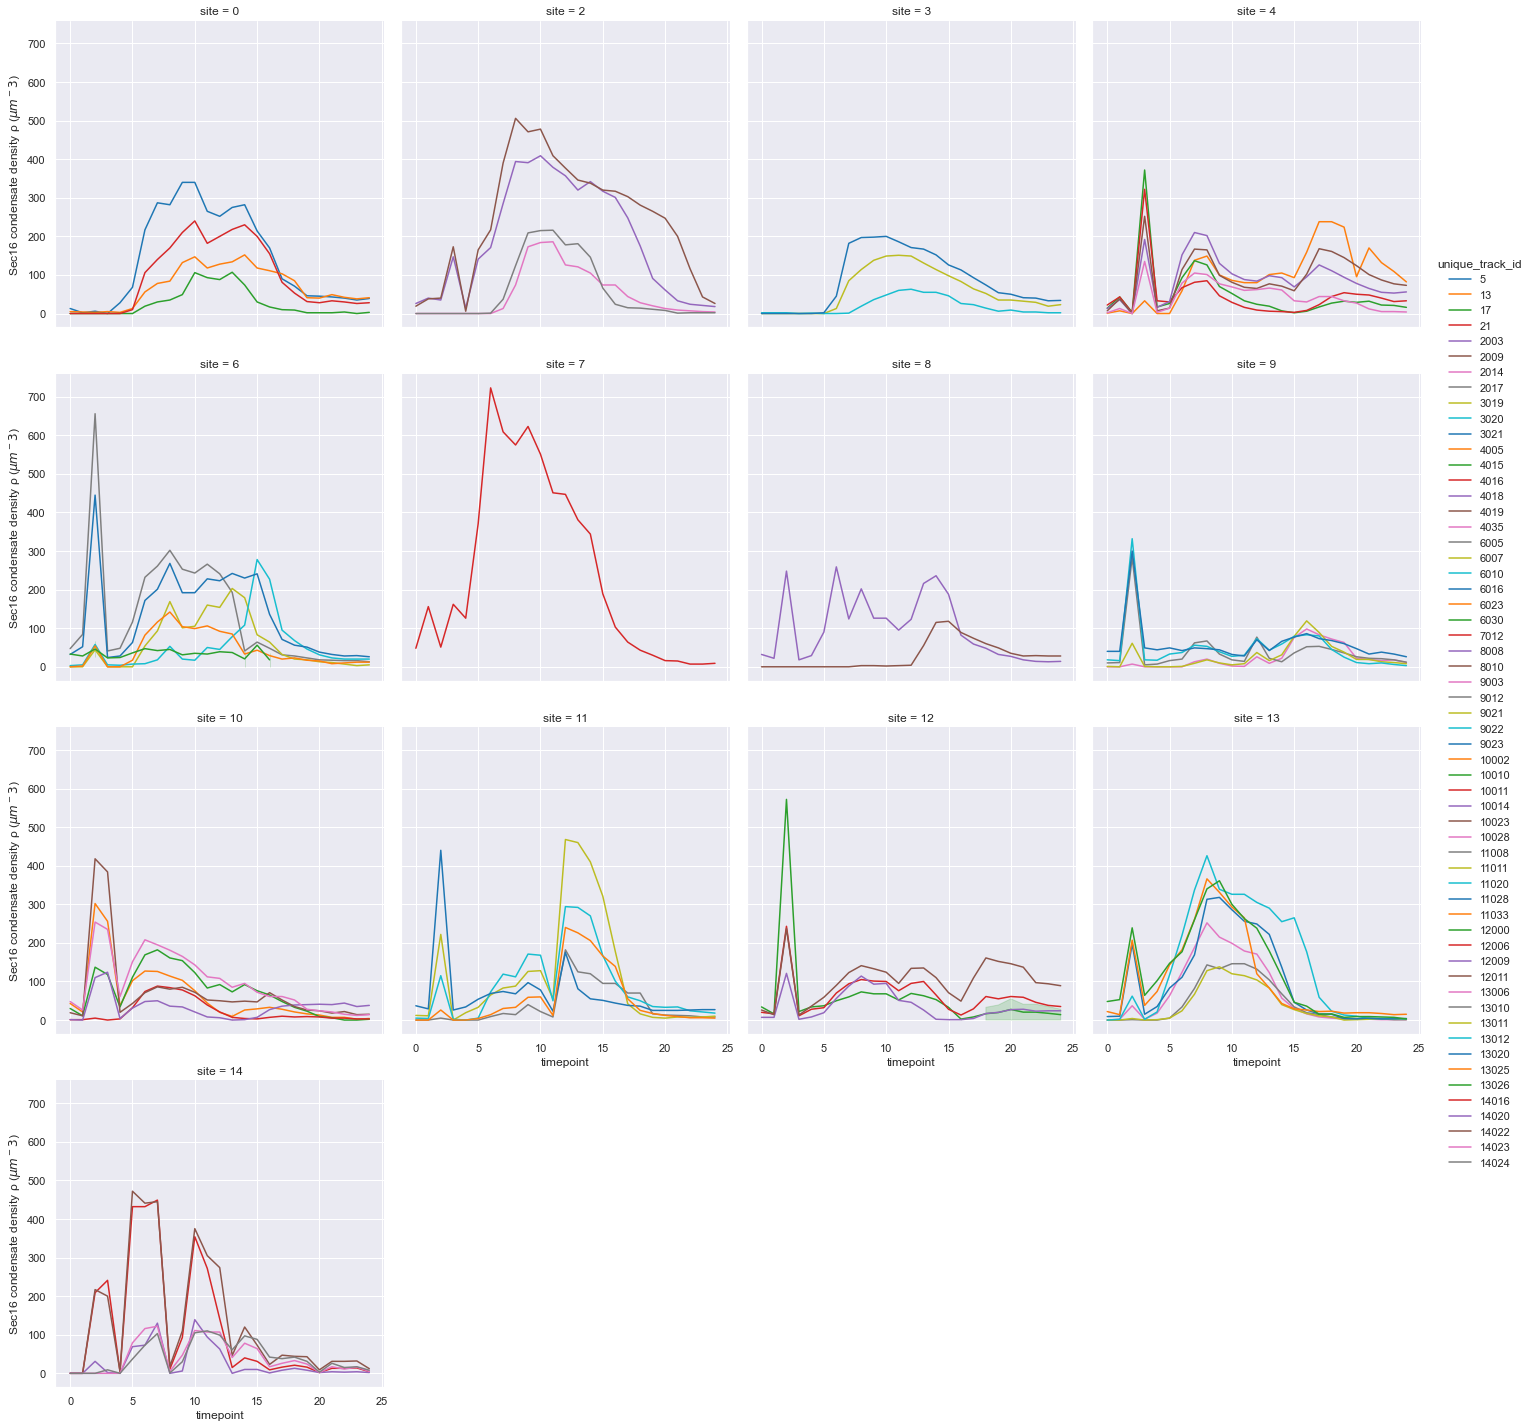

In [100]:
ax = sns.relplot(data=fv, x='timepoint', y='blob_count_sdcGFP', hue='unique_track_id', palette='tab10', col='site', kind='line', col_wrap=4)
ax.set(xlabel='timepoint', ylabel='Sec16 condensate density ρ ($\mu m^-3$)')

We need to define which sites we want to use. Choose only the ones that look good and add them to a list to filter the dataframe

In [101]:
# remove tracks from site that do not look good
good_sites = [0, 2, 3, 12, 13]
fv = fv.loc[fv['site'].isin(good_sites)]

For each cell track, we now have to define at which timepoint its nucleation starts. We do this by finding the first time the blob count of the track is above a certain threshold for more than k (k=3) frames.

In [102]:
# find t0 for each track
def find_t0(track, threshold, k):
    l = list(track['timepoint'].loc[track['blob_count_sdcGFP'] > threshold])
    l = [int(e) for e in l]

    for i, n in enumerate(l):
        # for every element, look at sublist with length k
        sublist = l[i:i+k]
        # return first occurence of elements in consecutive order
        if sublist == list(range(n, n+k)):
            return n - 1

t0 = fv.groupby('unique_track_id').apply(lambda track: find_t0(track, threshold=50, k=3))
fv = pd.merge(fv, t0.rename('t0'), on='unique_track_id')
fv = fv.dropna(subset=['t0'])



In [103]:
from scipy.optimize import curve_fit
from scipy.misc import derivative

In [105]:
def func(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d


def get_nucleation_rate(group):

    x_data = group['timepoint'].loc[group['timepoint'] >= group['t0']].iloc[0:5]
    y_data = group['blob_sdcGFP_cytoplasm_density'].loc[group['timepoint'] >= group['t0']].iloc[0:5]

    try:
        popt, pcov = curve_fit(func, x_data, y_data)
        der = derivative(func, x0=group['t0'].iloc[0], args=popt)
        prediction = func(group['timepoint'], *popt)

    except:
        print('no fit found for unique track id %d' % np.unique(group['unique_track_id']))
        der = np.nan
        prediction = [np.nan]*len(group['timepoint'])

    result = pd.DataFrame({'nucleation_rate': der, 'prediction': prediction, 'unique_object_id': group['unique_object_id']})

    return result


def get_Csat(group):
    return group['mean_intensity_sdcGFP_cells_eroded_2'].loc[group['timepoint'] == group['t0'] + 5]

def get_Cdil(group):
    return group['mean_intensity_sdcGFP'].loc[group['timepoint'] == group['t0']]


result = fv.groupby('unique_track_id').apply(lambda grp: get_nucleation_rate(grp))
C_sat = fv.groupby('unique_track_id').apply(lambda grp: get_Csat(grp))
C_dil = fv.groupby('unique_track_id').apply(lambda grp: get_Cdil(grp))


fv = pd.merge(fv, result.reset_index(), on='unique_object_id')
fv = pd.merge(fv, C_sat.rename('C_sat'), on='unique_track_id')
fv = pd.merge(fv, C_dil.rename('C_dil'), on='unique_track_id')

fv['S'] = np.log(fv['C_dil']/fv['C_sat'])

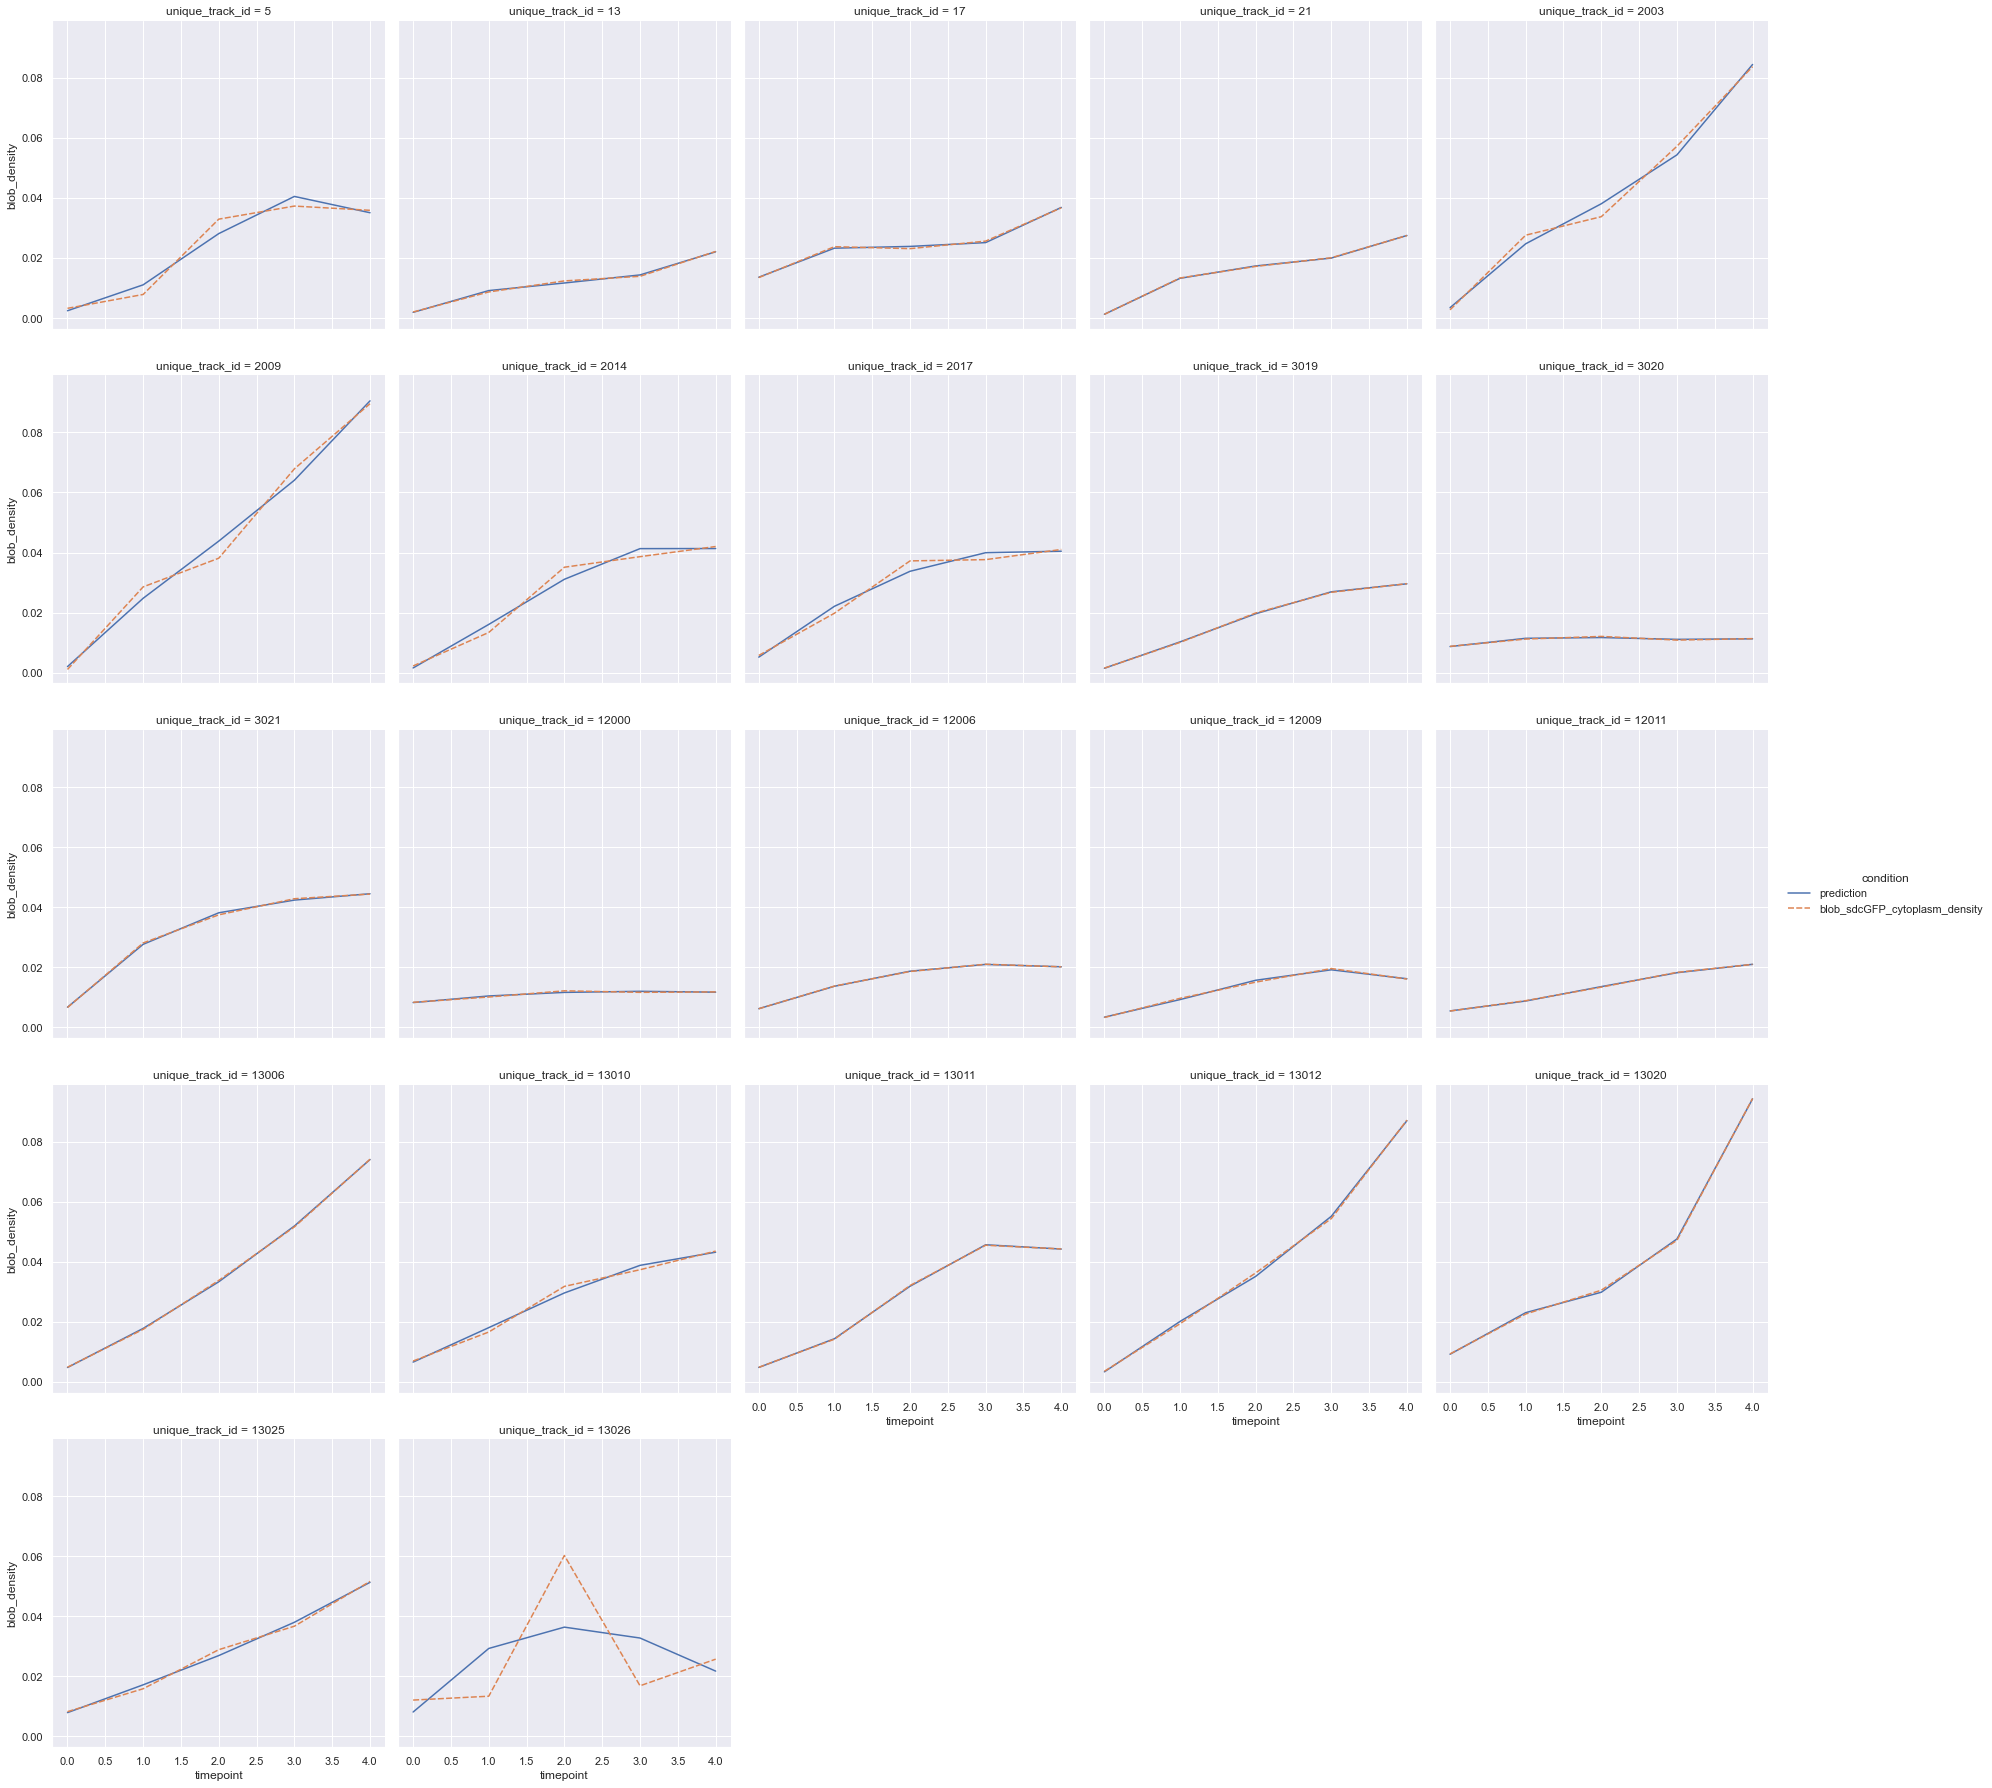

In [107]:
def get_timeframe(group):
    timeframe = np.arange(group['t0'].iloc[0], group['t0'].iloc[0]+5)
    group = group.loc[group['timepoint'].isin(timeframe)]
    group['timepoint'] = group['timepoint'] - group['t0']
    return group

plot_df = fv.groupby('unique_track_id').apply(lambda grp: get_timeframe(grp))
test = plot_df.melt(value_vars=['prediction', 'blob_sdcGFP_cytoplasm_density'], value_name='blob_density', var_name='condition',
                    id_vars=['timepoint', 'unique_track_id'])

sns.relplot(data=test, x='timepoint', y='blob_density', hue='condition', style='condition', col='unique_track_id', col_wrap=5, kind='line')
plt.show()


[(1e-05, 1)]

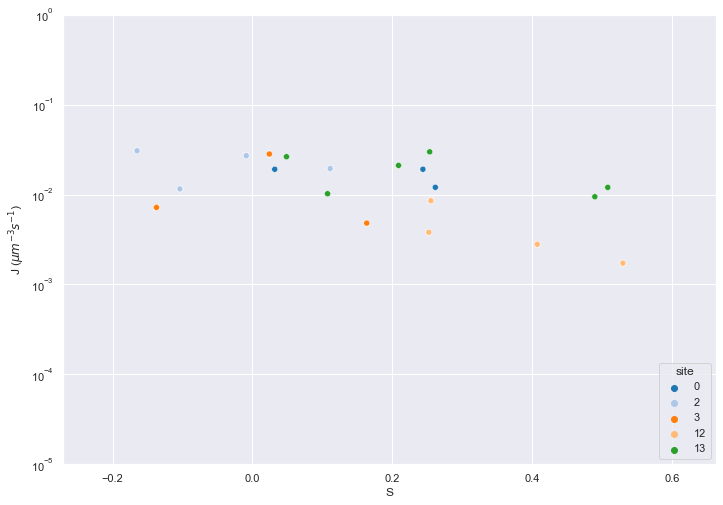

In [108]:
ax = sns.scatterplot(data=fv, x='S', y='nucleation_rate', hue='site', palette='tab20')
ax.set(xlabel='S', ylabel='J ($\mu m^{-3}s^{-1}$)')
plt.legend(loc='lower right', title='site')
ax.set(yscale="log")
ax.set(ylim=(10**-5, 10**0))

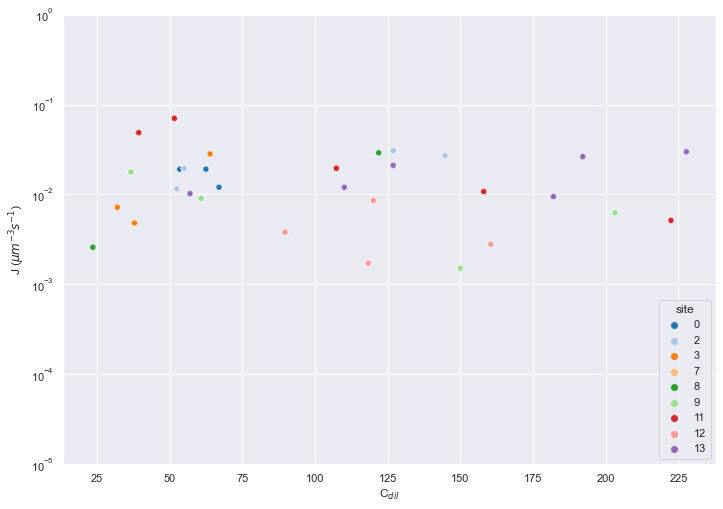

In [25]:
ax = sns.scatterplot(data=fv, x='C_dil', y='nucleation_rate', hue='site', palette='tab20')
ax.set(xlabel='C$_{dil}$', ylabel='J ($\mu m^{-3}s^{-1}$)')
plt.legend(loc='lower right', title='site')
ax.set(yscale="log")
ax.set(ylim=(10**-5, 10**0))

plt.show()

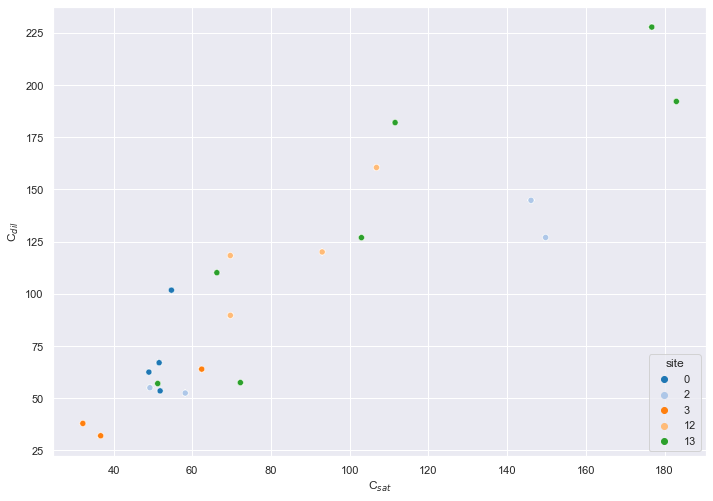

In [109]:
ax = sns.scatterplot(data=fv, x='C_sat', y='C_dil', hue='site', palette='tab20')
ax.set(xlabel='C$_{sat}$', ylabel='C$_{dil}$')
plt.legend(loc='lower right', title='site')
plt.show()

In [196]:
# plot for later nucleation when GFP is lower